# Análise geo espacial

```shell
$ pip install ipyleaflet
$ jupyter nbextension enable --py --sys-prefix ipyleaflet
```

In [3]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window

from datetime import datetime

from IPython.display import display, Latex, Math, Markdown
# from ipyleaflet import Map, basemaps, basemap_to_tiles

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import math
import pytz
import shutil
import pandas as pd

try:
    sc = SparkContext('local[*]')
    sc.setLogLevel("OFF")
    
except ValueError:
    # Prevent the notebook to crash if this block is executed more then once
    pass

spark = SparkSession(sc)

In [4]:
gps = spark.read.parquet("./data/ds/gps-log.parquet")
occupation = spark.read.parquet("./data/ds/occupation.parquet")

In [5]:
def save_csv(df, name):
    try:
        shutil.rmtree("./data/ds/%s" % name)
    except FileNotFoundError:
        pass
    df.coalesce(1).write.csv("./data/ds/%s" % name)

In [6]:
# gps.filter(col("date") == "2017-12-06").select("lat","long","speed","timestamp", "datetime").show()
# occupation.filter(col("timestamp") >= "2017-12-06").orderBy("timestamp").show()

next_col = Window.partitionBy("date").orderBy("timestamp").rowsBetween(Window.currentRow, 1)

avg_ride = Window.partitionBy("o.timestamp").orderBy("o.timestamp")

o = (
    occupation.alias("o")
    .withColumn("nextTimestamp", max("timestamp").over(next_col))
)

data = (
    gps.alias("g")
    .withColumn("kmh", col("speed") * 3.6)
    .join(
        o,
        (col("g.timestamp").cast("long") >= col("o.timestamp").cast("long")) &
        (col("g.timestamp").cast("long") <= col("nextTimestamp").cast("long")),
        "right"
    )
    .drop("nextTimestamp")
    .filter(col("o.date") != "12/12/2017")
    .filter(col("g.timestamp").isNotNull() & col("lat").isNotNull() & col("long").isNotNull())
    .select(
        "o.date",
        col("g.timestamp").alias("timestamp"),
        col("wifi_occupation").alias("wifi"), 
        col("real_occupation").alias("real"), 
        "o.direction",
        "kmh",
        "g.lat", 
        "g.long"
    )
)

save_csv(data, "gps_rides.csv")

data.toPandas()

,date,timestamp,wifi,real,direction,kmh,lat,long
0,08/12/2017,2017-12-08 19:59:38,3,2,0,4.9392,-23.654834,-46.713456
1,08/12/2017,2017-12-08 19:59:39,3,2,0,4.7448,-23.654818,-46.713431
2,08/12/2017,2017-12-08 19:59:40,3,2,0,5.1012,-23.654831,-46.713492
3,08/12/2017,2017-12-08 19:59:41,3,2,0,4.1328,-23.654833,-46.713476
4,08/12/2017,2017-12-08 19:59:42,3,2,0,2.8800,-23.654830,-46.713470
5,08/12/2017,2017-12-08 19:59:43,3,2,0,2.9160,-23.654832,-46.713474
6,08/12/2017,2017-12-08 19:59:44,3,2,0,4.1292,-23.654825,-46.713453
7,08/12/2017,2017-12-08 19:59:45,3,2,0,4.1364,-23.654825,-46.713414
8,08/12/2017,2017-12-08 19:59:46,3,2,0,3.8880,-23.654822,-46.713403
9,08/12/2017,2017-12-08 19:59:47,3,2,0,2.7576,-23.654816,-46.713403


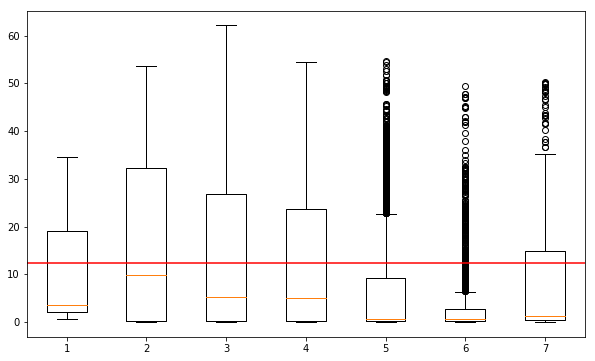

In [9]:
d = data.toPandas()

fig, ax = plt.subplots(figsize=(10, 6))

ax.boxplot([d.groupby('wifi')['kmh'].get_group(i).values for i in [1,2,3,4,5,6,7]])
plt.axhline(d['kmh'].mean(), color='r')
plt.show()

# Entre-picos


**Produtos da dissertação**
- Documentação do Software
- Mapa de carregamento
- 

**Artigo**
- Método de ocupação de janela deslizante
    - Resultados estatísticos
- Mapa de temperatura
    - Carregamento por trecho
    - Principais pontos
- Velocidade / Ocupação